In [ ]:
from pandas.errors import InvalidIndexError
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
train_df=pd.read_csv('/content/in_domain_train.tsv',delimiter='\t',header=None,
                names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [ ]:
train_df.shape

(8551, 4)

In [ ]:
train_df.head()

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"our friends wo n't buy this analysis , let alo..."
1,gj04,1,NaN,one more pseudo generalization and i 'm giving...
2,gj04,1,NaN,one more pseudo generalization or i 'm giving ...
3,gj04,1,NaN,"the more we study verbs , the crazier they get ."
4,gj04,1,NaN,day by day the facts are getting murkier .


# EDA

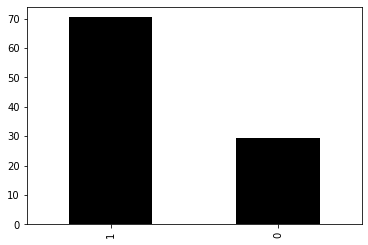

In [ ]:
(train_df.label.value_counts(normalize=True)*100).plot(kind='bar',color='black');

We can observe that Data is Imbalanced 

In [ ]:
incorrect=' '.join(words for words in train_df[train_df['label']==0].sentence)

In [ ]:
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image

In [ ]:
len(STOPWORDS)

190

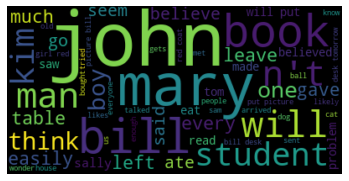

In [ ]:
word_cloud=WordCloud(stopwords=STOPWORDS,max_words=60,background_color='black').generate(incorrect)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
correct=' '.join(words for words in train_df[train_df['label']==1].sentence)

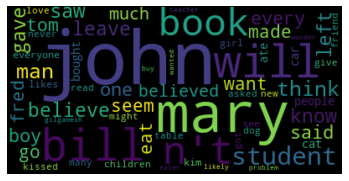

In [ ]:
word_cloud=WordCloud(stopwords=STOPWORDS,max_words=60,background_color='black').generate(correct)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# INSTALL TRANSFORMERS

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.5 MB/s 
     |████████████████████████████████| 67 kB 3.8 MB/s 
     |████████████████████████████████| 6.5 MB 29.2 MB/s 
     |████████████████████████████████| 596 kB 43.9 MB/s 
     |████████████████████████████████| 895 kB 43.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sentences=train_df.sentence.values
labels=train_df.label.values

#TOKENIZE SENTENCES

In [ ]:
max_len = 0
for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


In [ ]:
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                     
                        add_special_tokens = True, 
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True,   
                        return_tensors = 'pt',     
                   )
    
    
    input_ids.append(encoded_dict['input_ids'])
    
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(np.round((0.8 * len(dataset))))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:} training samples'.format(train_size))
print('{:} validation samples'.format(val_size))

6841 training samples
1710 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(
            train_dataset, 
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False,
)
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np
def get_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np
seed_val = 2022

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []

total_t0 = time.time()
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
      
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        
        model.zero_grad()        

       
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

      
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    
    training_time = format_time(time.time() - t0)

    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        
        loss = result.loss
        logits = result.logits
            
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        
        total_eval_accuracy += get_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Average training loss: 0.52
  Training epcoh took: 0:02:18
Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.44
  Validation took: 0:00:12

======== Epoch 2 / 3 ========
Training...
  Average training loss: 0.32
  Training epcoh took: 0:02:19
Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.45
  Validation took: 0:00:12

======== Epoch 3 / 3 ========
Training...
  Average training loss: 0.21
  Training epcoh took: 0:02:19
Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.53
  Validation took: 0:00:12
Training complete!
Total training took 0:07:31 (h:mm:ss)


In [ ]:
import pandas as pd
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.52,0.44,0.81,0:02:18,0:00:12
2,0.32,0.45,0.82,0:02:19,0:00:12
3,0.21,0.53,0.82,0:02:19,0:00:12


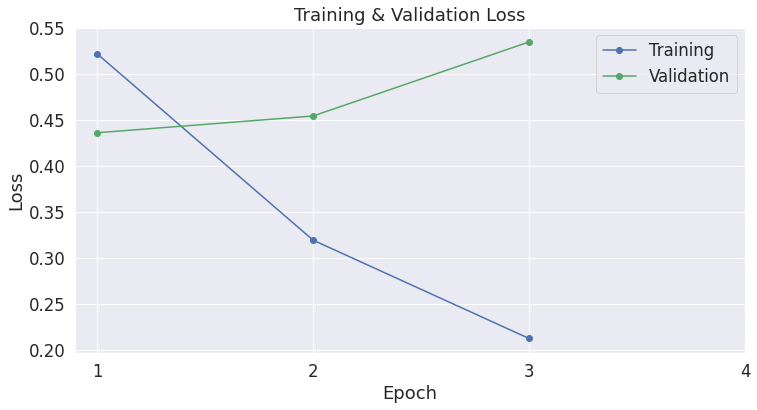

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

#ON TEST DATA

## Preparing Data

In [ ]:
import pandas as pd
test_df=pd.read_csv('/content/out_of_domain_dev.tsv',header=None,delimiter='\t',
                    names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [ ]:
test_df.head()

,sentence_source,label,label_notes,sentence
0,clc95,1,NaN,somebody just left - guess who .
1,clc95,1,NaN,"they claimed they had settled on something , b..."
2,clc95,1,NaN,"if sam was going , sally would know where ."
3,clc95,1,NaN,"they 're going to serve the guests something ,..."
4,clc95,1,NaN,she 's reading . i ca n't imagine what .


In [ ]:
test_df.shape

(516, 4)

In [ ]:
sentences=test_df.sentence.values
labels=test_df.label.values

In [ ]:
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                     
                        add_special_tokens = True, 
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',     
                   )
    
   
    input_ids.append(encoded_dict['input_ids'])
    
    
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
  
batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
import torch.nn.functional as F

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
probs=[]
model.eval()
 
predictions , true_labels = [], []


for batch in prediction_dataloader:

  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits
  proba= F.softmax(logits,dim=1).cpu().numpy()
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
 
  predictions.append(logits)
  probs.append(proba)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []
for i in range(len(true_labels)):
  
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
 
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

In [ ]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.524


#Predicting grammatical acccuracy

In [ ]:
review_df=pd.read_csv('/content/review_data.csv')

In [ ]:
review_df.head()

,text,star,app_id,reviewDate
0,Anathi Khanyile,5,com.fingersoft.hillclimb,18/03/21
1,Tony bahut funny hai Hill climbing racing my f...,5,com.fingersoft.hillclimb,18/03/21
2,Teturwu,1,com.fingersoft.hillclimb,18/03/21
3,Hoooooooooooyaaaaaaaaa what a game hoooooooooo...,5,com.fingersoft.hillclimb,18/03/21
4,This game is nice,5,com.fingersoft.hillclimb,18/03/21


In [ ]:
review_df.dropna(inplace=True)

In [ ]:
review_df.isnull().sum()

text          0
star          0
app_id        0
reviewDate    0
dtype: int64

In [ ]:
sentences=review_df.text.values

In [ ]:
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                     
                        add_special_tokens = True, 
                        max_length = 64,           
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',     
                   )
    
   
    input_ids.append(encoded_dict['input_ids'])
    
    
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
probs=[]
model.eval()
 
predictions = []


for batch in prediction_dataloader:

  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch

  with torch.no_grad():
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

 logits = result.logits
  proba= F.softmax(logits,dim=1).cpu().numpy()
  logits = logits.detach().cpu().numpy()
 
  predictions.append(logits)
  probs.append(proba)

print('    DONE.')

    DONE.


In [ ]:
probability_score=np.ravel(probs)

In [ ]:
grammatical_accuracy=[]
for i in range(len(probability_score)):
  for j in range(len(probability_score[i])):
    grammatical_accuracy.append(max(probability_score[i][j]))


In [ ]:
acc_df = pd.Series(grammatical_accuracy)*100


In [ ]:
acc_df

0        90.78
1        77.01
2        95.18
3        70.95
4        98.55
         ...  
29994    71.95
29995    89.24
29996    97.89
29997    89.22
29998    98.38
Length: 29999, dtype: float32

In [ ]:
review_df['Grammatical_acuracy']=acc_df

In [ ]:
review_df.isnull().sum()

text                   0
star                   0
app_id                 0
reviewDate             0
Grammatical_acuracy    1
dtype: int64

In [ ]:
review_df.dropna(inplace=True)

In [ ]:
final=review_df.drop(['star','app_id','reviewDate'],axis=1)

In [ ]:
from google.colab import files
final.to_csv('grammatical_accuracy.csv') 
files.download('grammatical_accuracy.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>